In [1]:
import mlflow
import mlflow.lightgbm
import numpy as np
import pandas as pd
import optuna
from lightgbm import LGBMClassifier
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pandas as pd
import os
import random
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
from utils import custom_train_test_split, lgbm_predict, title2filename

## MLflow 설정

In [ ]:
mlflow.get_tracking_uri()

In [2]:
os.environ["LOGNAME"] = "lnh"
remote_server_uri="http://118.67.134.110:30005"
mlflow.set_tracking_uri(remote_server_uri)

client = mlflow.tracking.MlflowClient()
experiment_name = "LGBM optuna"
try:
    experiment_id = client.create_experiment(experiment_name)
except:
    experiment = client.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id
experiment_id

'271919591702384430'

## 데이터 불러오기 및 split

In [3]:
SEED=13

## 1. 데이터 로딩
data_dir = '/opt/ml/input/data' # 경로
after_fe_path = os.path.join(data_dir, 'base_lgbm2.pkl')
df = pd.read_pickle(after_fe_path)

train_df = df[df.kind=='train']
train, valid = custom_train_test_split(train_df, ratio=0.7, seed=SEED) # 훈련데이터 split
test = df[df.kind=='test'] # 테스트 데이터
train2 = test[test.answerCode!=-1] # 테스트데이터 마지막 제출 2번쨰꺼까지 훈련데이터로 사용
train = pd.concat([train,train2]) # 훈련데이터 병합
train.shape, valid.shape, test.shape

x_train = train.drop('answerCode',axis=1)
y_train = train[['answerCode']]

x_valid = valid.drop('answerCode',axis=1)
y_valid = valid[['answerCode']]
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((1845539, 58), (1974, 58), (260114, 58))

((1845539, 57), (1845539, 1), (1974, 57), (1974, 1))

In [4]:
# @mlflc.track_in_mlflow()
def objective(trial: Trial) -> float:
    # Hyper parameter 설정
    params = {
    #     "max_depth": 8,  # 8,
    #     "min_data_in_leaf": 1000,
        # "feature_fraction": 0.6,  # 0.8,
    #     "bagging_fraction": 0.75,
        # "max_cat_group": 64,
        "objective": "binary",
    #     "boosting": "gbdt",  # dart
        "learning_rate": 0.023,  # 0.01,
        # "bagging_freq": 5,
        "seed": 42,
        # "max_bin": 50,
    #     "num_leaves": 80,  # 40,
    #     "metric": "auc",
    }

    ### 피처 설정
    # 사용할 Feature 설정
    FEATS = ['uidIdx',
             'assIdx',
             'testIdx',
             'KnowledgeTag',
             'user_correct_answer',
             'user_total_answer',
             'big_category',
             'mid_category',
             'problem_num',
             'month','day','dayname','hour',
             'test_mean',
             'test_sum',
             'test_std',
             'tag_std',
             'tag_mean',
             'tag_sum',
             'solvesec_3600',
             'time_category',
             'solvesec_cumsum',
             'solvecumsum_category',
             'big_category_cumconut',
             'big_category_user_cum_acc',
             'mid_category_cumconut',
             'mid_category_user_cum_acc',
             'assess_count',
             'elo_assessmentItemID',
             'elo_problem_num',
            ]

    cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
                 'problem_num','dayname','month','time_category','solvecumsum_category']
    cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

    ### 학습 및 예측

    date = datetime.now().strftime('%m/%d %a')
    title=f"🌈({date})[LGBM] optuna"
    using_feats=", ".join(FEATS)
    desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
    cat_feats_idx, title, desc

    lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
    lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

    model_lgbm = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model_lgbm.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    # model_run_id=run.info.run_id
    # post_slack("done")
    # print(f"{model_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model_lgbm, FEATS, f'{file_name}.csv')

    q = pd.Series(test_preds).plot(kind='kde')
    return auc

[I 2022-12-07 17:06:22,287] A new study created in memory with name: lgbm_parameter_opt


Optimize a model...


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19967
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.531009
[200]	valid_0's binary_logloss: 0.517541
[300]	valid_0's binary_logloss: 0.513531
[400]	valid_0's binary_logloss: 0.511328
[500]	valid_0's binary_logloss: 0.509576
[600]	valid_0's binary_logloss: 0.507943
[700]	valid_0's binary_logloss: 0.506832
[800]	valid_0's binary_logloss: 0.505703
[900]	valid_0's binary_logloss: 0.505156
[100

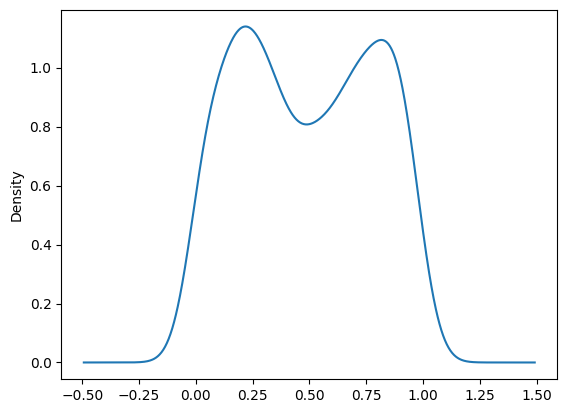

In [5]:
from optuna.integration.mlflow import MLflowCallback
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

print("Optimize a model...")


remote_server_uri="http://118.67.134.110:30005"
def make_mlflow_callback():
    cb = MLflowCallback(
         tracking_uri = mlflow.get_tracking_uri(),
         metric_name="VAL AUC",
         create_experiment=True)
    return cb

mlflow_cb = make_mlflow_callback()

study.optimize(
    objective, n_trials=1, callbacks=[mlflow_cb], show_progress_bar=True
)

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19967
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.531009
[200]	valid_0's binary_logloss: 0.517541
[300]	valid_0's binary_logloss: 0.513531
[400]	valid_0's binary_logloss: 0.511328
[500]	valid_0's binary_logloss: 0.509576
[600]	valid_0's binary_logloss: 0.507943
[700]	valid_0's binary_logloss: 0.506832
[800]	valid_0's binary_logloss: 0.505703
[900]	valid_0's binary_logloss: 0.505156
[100

[I 2022-12-07 17:11:35,981] Trial 1 finished with value: 0.8325649286525453 and parameters: {}. Best is trial 0 with value: 0.8325649286525453.
Traceback (most recent call last):
  File "/opt/conda/envs/dkt2/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 279, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/opt/conda/envs/dkt2/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 372, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/opt/conda/envs/dkt2/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 1082, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/opt/conda/envs/dkt2/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 1075, in _read_helper
    result = read_yaml(root, file_name)
  File "/opt/conda/envs/dkt2/lib/python3.9/site-packages/mlflow/utils/file_utils.py", line

VALID AUC : 0.8325649286525453 ACC : 0.7553191489361702

writing prediction : output/12_07_Wed_LGBM_optuna.csv


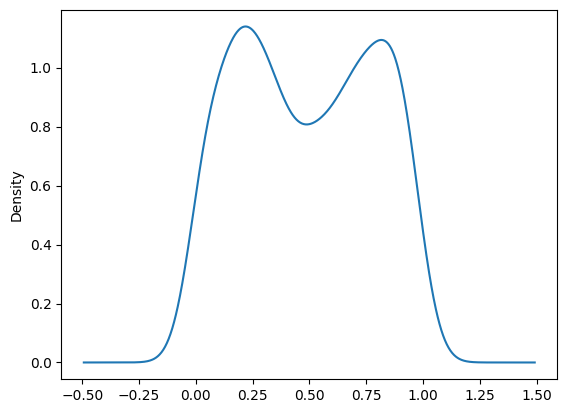

In [6]:
from optuna.integration.mlflow import MLflowCallback
 
def make_mlflow_callback():
    cb = MLflowCallback(
         tracking_uri="mlruns",
         metric_name="VALID AUC",
         create_experiment=True)
    return cb
 
mlflow_cb = make_mlflow_callback()
study.optimize(objective, n_trials=1, callbacks=[mlflow_cb])

In [ ]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-12-07 17:05:37,037] A new study created in memory with name: lgbm_parameter_opt


[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19967
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.531009
